# SLAM Unit A - Part 3
In this part 3 of Unit A, we will start to work with the laser scanner.

In [50]:
# You can modify the following to adjust the (width, height) of the plots (supposed to be in inches).
from pylab import *
plt.rcParams['figure.figsize'] = (12, 6)
# YouTube = True  # Uncomment to get YouTube videos instead of TIB AV.

## Sensor data: laser scanner (LiDAR) data and its derivative

In [51]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/_rGseGPtS7g" if "YouTube" in globals() else "//av.tib.eu/player/49054",
       width=560, height=315)

### First look at the motor ticks vs. reference trajectory by yourself!

In [52]:
# Execute this to run the interactive viewer.
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["poses_from_ticks.txt", "robot4_reference.txt", "robot4_scan.txt"])

### Plot a scan.
Just as in the video, we plot one scan, i.e. a graph that shows the measured distance for every scan ray that was emitted during one scanner revolution.

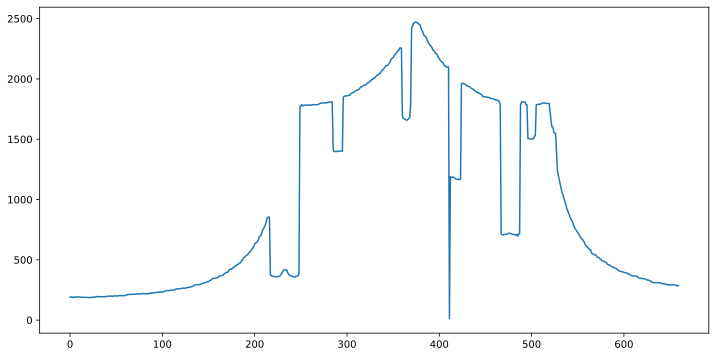

In [53]:
# Plot a scan of the robot using matplotlib.
# 03_a_plot_scan
from pylab import *
from lego_robot import *

# Read the logfile which contains all scans.
logfile = LegoLogfile()
logfile.read("robot4_scan.txt")

# Plot one scan. Try to replace the scan number by another one.
plot(logfile.scan_data[8])
show()

### Interactively step through all scans.
Now here is something cool, execute the following cell and then move the slider which appears to select a scan.
- Once you clicked on the slider, you can also use the 'cursor left' and 'cursor right' keys to step through all scans.
- If you are keen on experimenting, then replace the 'continuous_update=False' by 'continuous_update=True' to see the graph change while you move the slider. (By default, I have set it to False, since the time lag may accumulate and the user interface may become unresponsive.)

In [54]:
import ipywidgets as ipyw
def plot_scan(scan_id):
    plot(logfile.scan_data[scan_id])
    ylim(0, 2500)
ipyw.interact(plot_scan, scan_id = ipyw.IntSlider(min=0, max=len(logfile.scan_data)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='scan_id', max=277), Output()), …

<function __main__.plot_scan>

### Compute the derivative of a scan (10 points).
Next, please implement the formula for the discrete derivative (also known as difference quotient), as explained in the video above.

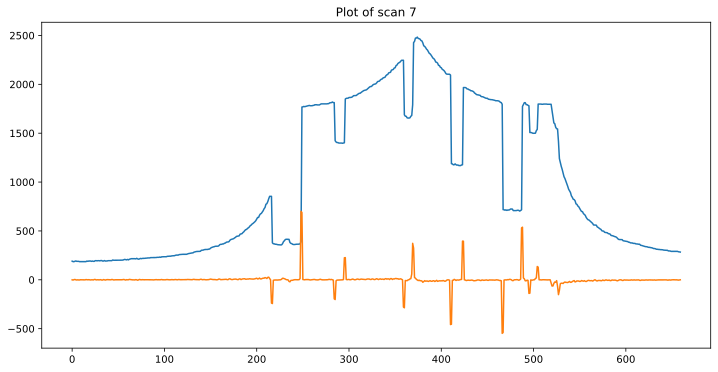

In [55]:
# Compute the derivative of a scan.
# 03_b_scan_derivative
from pylab import *
from lego_robot import *

# Find the derivative in scan data, ignoring invalid measurements.
def compute_derivative(scan, min_dist):
    jumps = [ 0 ]
    for i in range(1, len(scan) - 1):
        # Compute derivative using formula "(f(i+1) - f(i-1)) / 2".
        # Do not use erroneous scan values, which are below min_dist.

        # The following line is an example of how to append values.
        # Make sure to delete it from your final solution.
        ####jumps.append(i%20 * 10)
        # YOUR CODE HERE
        if scan[i-1]>min_dist and scan[i+1]>min_dist:
            d=(scan[i+1] - scan[i-1])/2
            jumps.append(d) 
        else:
            jumps.append(0)
        #raise NotImplementedError()
    jumps.append(0)
    return jumps

if __name__ == '__main__':

    minimum_valid_distance = 20.0      #有效测量值的最小距离

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_scan.txt")

    # Pick one scan.
    scan_no = 7
    scan = logfile.scan_data[scan_no]

    # Compute derivative, (-1, 0, 1) mask.
    der = compute_derivative(scan, minimum_valid_distance)

    # Plot scan and derivative.
    title("Plot of scan %d" % scan_no)
    plot(scan)
    plot(der)
    show()

### You may step through the scans and derivatives using the following cell.

In [56]:
minimum_valid_distance = 20.0
def plot_scan_and_derivative(scan_id):
    scan = logfile.scan_data[scan_id]
    der = compute_derivative(scan, minimum_valid_distance)
    plot(scan)
    plot(der)
    ylim(-600, 2500)
ipyw.interact(plot_scan_and_derivative,
              scan_id = ipyw.IntSlider(min=0, max=len(logfile.scan_data)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='scan_id', max=277), Output()), …

<function __main__.plot_scan_and_derivative>

### Finally, some checks.

In [57]:
# Here are two tests which your function should pass.
def public_test(the_derivative_function):
    # If the scan is:
    scan = [ 201, 500, 204 ]
    # Then, due to our approach, the first and last values will be zero,
    # while the middle value will be (204 - 201) / 2 = 3/2 = 1.5.
    result = [ 0, 1.5, 0 ]
    if the_derivative_function(scan, 20.0) != result:
        print("Did not work for", scan)
        return False

    # Make a longer example. This contains an invalid value, 9.
    # Therefore, the derivatives which would use this value, are set to zero.
    # (These are the two values to the left and right of the value 9.)
    scan   = [ 200, 202, 203, 207,   9, 214, 230, 219 ]
    result = [   0, 1.5, 2.5,   0, 3.5,   0, 2.5,   0 ]
    if the_derivative_function(scan, 20.0) != result:
        print("Did not work for", scan)
        return False

    return True

assert(public_test(compute_derivative))

## Finding cylinders in the scan data

In [58]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/JBr3dpvvmVo" if "YouTube" in globals() else "//av.tib.eu/player/49055",
       width=560, height=315)

### Finding the ray and depth of every cylinder (20 points).
Please implement the algorithm from the video. **Note that in order to get a more robust result, you should implement it as it is described in the following.**

Since the first and last rays hitting a pole are sometimes affected by the so-called *mixed point* effect (part of the ray footprint hits the pole, part of it hits the background), we would like to discard them.

That is, for the example in the video, we would like to compute the pole from the rays 8 and 9 only, and not, as shown in the video, from the rays 7, 8, 9, and 10.

Therefore, your algorithm should have the following structure:
- when encountering a strongly negative derivative, initialize the counters with zero, and do not use the values of the current ray
- conversely, when encountering a strongly positive derivative, compute the cylinder from the current counter values, but do not include the values of the current ray
- in all other cases, if the measurement is part of a cylinder, and the measurement is valid, update the counters.

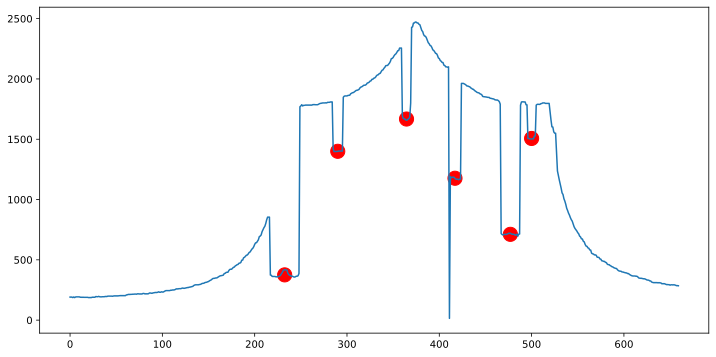

In [59]:
# For each cylinder in the scan, find its ray and depth.
# 03_c_find_cylinders
from pylab import *
from lego_robot import *

# Find the derivative in scan data, ignoring invalid measurements.
def compute_derivative(scan, min_dist):
    jumps = [ 0 ]
    for i in range(1, len(scan) - 1):
        l = scan[i-1]
        r = scan[i+1]
        if l > min_dist and r > min_dist:
            derivative = (r - l) / 2.0
            jumps.append(derivative)
        else:
            jumps.append(0)

    jumps.append(0)
    return jumps

# For each area between a left falling edge and a right rising edge,
# determine the average ray number and the average depth.
def find_cylinders(scan, scan_derivative, jump, min_dist):
    cylinder_list = []
    on_cylinder = False
    sum_ray, sum_depth, rays = 0.0, 0.0, 0

    for i in range(len(scan_derivative)):
        # Whenever you find a cylinder, add a tuple
        # (average_ray, average_depth) to the cylinder_list.

        # Just for fun, I'll output some cylinders.
        # Make sure to delete the following two lines in your final solution.
        ####if i % 100 == 0:
            ####cylinder_list.append( (i, scan[i]) )

        # YOUR CODE HERE



        if scan_derivative[i] < -depth_jump :
            on_cylinder = True
            sum_ray, sum_depth, rays = 0.0, 0.0, 0
            
        elif scan_derivative[i] > depth_jump and on_cylinder == True:
            on_cylinder = False
            average_ray = sum_ray / rays
            average_depth = sum_depth / rays
            cylinder_list.append( (average_ray, average_depth) )

        elif on_cylinder == True and scan[i] > minimum_valid_distance:
            rays += 1
            sum_ray += i
            sum_depth += scan[i]

        #raise NotImplementedError()
        
    return cylinder_list


if __name__ == '__main__':

    minimum_valid_distance = 20.0
    depth_jump = 100.0

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_scan.txt")

    # Pick one scan.
    scan = logfile.scan_data[8]

    # Find cylinders.
    der = compute_derivative(scan, minimum_valid_distance)
    cylinders = find_cylinders(scan, der, depth_jump,
                               minimum_valid_distance)

    # Plot results.
    plot(scan)
    scatter([c[0] for c in cylinders], [c[1] for c in cylinders],
        c='r', s=200)
    show()

### Let's do an interactive plot.
Step through the scans to see how the detection works.

In [60]:
minimum_valid_distance = 20.0
depth_jump = 100.0
def plot_scan_and_cylinders(scan_id):
    scan = logfile.scan_data[scan_id]
    der = compute_derivative(scan, minimum_valid_distance)
    cylinders = find_cylinders(scan, der, depth_jump, minimum_valid_distance)
    plot(scan)
    scatter([c[0] for c in cylinders], [c[1] for c in cylinders], c='r', s=200)
    ylim(0, 2500)
ipyw.interact(plot_scan_and_cylinders,
              scan_id = ipyw.IntSlider(min=0, max=len(logfile.scan_data)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='scan_id', max=277), Output()), …

<function __main__.plot_scan_and_cylinders>

In [61]:
# Let us test a simple case.
def public_test(derivative_function, find_cylinder_function):
    minimum_valid_distance = 20.0
    depth_jump = 100.0

    # Say this is the scan.
    s = [ 500,  502,  503,  100, 103, 105, 101,  15, 102,   510, 505 ]
    # Then the derivative is:
    d = [   0,  1.5, -201, -200, 2.5,  -1,   0, 0.5,   0, 201.5,   0 ]
    # Where the two zeros in the middle are due to 15 < minimum_valid_distance.
    # Now remember we start at a strong negative derivative --- and end at a
    # strong positive derivative +++, but we do not include those values.
    # Also, we do not include distances below the minimum threshold, ooo.
    # So we only include the values marked with ***.
    #   [   0,  1.5, -201, -200, 2.5,  -1,   0, 0.5,   0, 201.5,   0 ]
    #                 ---   ---  ***  ***  ***  ooo  ***  +++
    # ray   0     1     2     3    4    5    6    7    8    9     10
    # distance                   103  105  101       102
    #
    # So the average ray is (4+5+6+8) / 4 = 23/4 = 5.75
    # and the average distance is (103+105+101+102) / 4 = 411 / 4 = 102.75.
    der = derivative_function(s, minimum_valid_distance)
    cyl = find_cylinder_function(s, der, depth_jump, minimum_valid_distance)

    return cyl == [(5.75, 102.75)]

assert((public_test(compute_derivative, find_cylinders)))

### Computing cartesian coordinates.
We convert the (angle, distance) pairs to (x,y) coordinates in the robot's coordinate system.

In [62]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/rrg9BtfxdhM" if "YouTube" in globals() else "//av.tib.eu/player/48981",
       width=560, height=315)

### Programming assignment: converting to cartesian coordinates (10 points).

In [63]:
# For each cylinder in the scan, find its cartesian coordinates,
# in the scanner's coordinate system.
# Write the result to a file which contains all cylinders, for all scans.
# 03_d_find_cylinders_cartesian
from lego_robot import *
from math import sin, cos

# Find the derivative in scan data, ignoring invalid measurements.
def compute_derivative(scan, min_dist):
    jumps = [ 0 ]
    for i in range(1, len(scan) - 1):
        l = scan[i-1]
        r = scan[i+1]
        if l > min_dist and r > min_dist:
            derivative = (r - l) / 2.0
            jumps.append(derivative)
        else:
            jumps.append(0)

    jumps.append(0)
    return jumps

# For each area between a left falling edge and a right rising edge,
# determine the average ray number and the average depth.
def find_cylinders(scan, scan_derivative, jump, min_dist):
    cylinder_list = []
    on_cylinder = False
    sum_ray, sum_depth, rays = 0.0, 0.0, 0

    for i in range(len(scan_derivative)):
        # Whenever you find a cylinder, add a tuple
        # (average_ray, average_depth) to the cylinder_list.

        # Just for fun, I'll output some cylinders.
        # Make sure to delete the following two lines in your final solution.
        ####if i % 100 == 0:
            ####cylinder_list.append( (i, scan[i]) )

        # YOUR CODE HERE
        
        if scan_derivative[i] < -depth_jump :
            on_cylinder = True
            sum_ray, sum_depth, rays = 0.0, 0.0, 0
            
        elif scan_derivative[i] > depth_jump and on_cylinder == True:
            on_cylinder = False
            average_ray = sum_ray / rays
            average_depth = sum_depth / rays
            cylinder_list.append( (average_ray, average_depth) )

        elif on_cylinder == True and scan[i] > minimum_valid_distance:
            rays += 1
            sum_ray += i
            sum_depth += scan[i] 
        #raise NotImplementedError()
        
    return cylinder_list

def compute_cartesian_coordinates(cylinders, cylinder_offset):
    result = []
    for c in cylinders:
        # --->>> Insert here the conversion from polar to Cartesian coordinates.
        # c is a tuple (beam_index, range).
        # For converting the beam index to an angle, use
        # LegoLogfile.beam_index_to_angle(beam_index)
        # Make sure to delete the following line from your final solution.
        ####result.append( (0,0) ) # Replace this by your (x,y).
        # YOUR CODE HERE
        c_angle=LegoLogfile.beam_index_to_angle(c[0])
        c_range=c[1]+cylinder_offset
        x=c_range*cos(c_angle)
        y=c_range*sin(c_angle)
        result.append( (x,y) )
        #raise NotImplementedError()
    return result
        

if __name__ == '__main__':

    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_scan.txt")

    # Write a result file containing all cylinder records.
    # Format is: D C x[in mm] y[in mm] ...
    # With zero or more points.
    # Note "D C" is also written for otherwise empty lines (no
    # cylinders in scan)
    out_file = open("cylinders.txt", "w")
    for scan in logfile.scan_data:
        # Find cylinders.
        der = compute_derivative(scan, minimum_valid_distance)
        cylinders = find_cylinders(scan, der, depth_jump,
                                   minimum_valid_distance)
        cartesian_cylinders = compute_cartesian_coordinates(cylinders,
                                                            cylinder_offset)
        # Write to file.
        print("D C", end=' ', file=out_file)
        for c in cartesian_cylinders:
            print("%.1f %.1f" % c, end=' ', file=out_file)
        print(file=out_file)
    out_file.close()

In [67]:
# Lets test one example.
from math import isclose
def public_test(derivative_function, cylinder_function, cartesian_function):
    # For the given scan:
    s = [ 1000, 1000, 100, 102, 104, 1000, 1000 ]
    # We would expect this output:
    r = [(-92.968938011221766, -167.99040616971436)]

    # So lets check it.
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0
    der = derivative_function(s, minimum_valid_distance)
    cyl = cylinder_function(s, der, depth_jump, minimum_valid_distance)
    cart = cartesian_function(cyl, cylinder_offset)

    return isclose(r[0][0], cart[0][0]) and isclose(r[0][1], cart[0][1])
assert(public_test(compute_derivative, find_cylinders, compute_cartesian_coordinates))

## Congratulations, you finished Unit A
Let's have a look at what you have learned!

In [65]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/uz-ckOO8w9s" if "YouTube" in globals() else "//av.tib.eu/player/48982",
       width=560, height=315)

### Take a look by yourself, using the interactive viewer.

In [66]:
# Execute this to run the interactive viewer.
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["robot4_scan.txt", "cylinders.txt", "robot4_reference.txt",
                                "robot_arena_landmarks.txt", "poses_from_ticks.txt"])